# DCGAN — Bug-Fix Labs - 10 Bugs

In [1]:
import torch, torchvision
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
# ---------------------------
# Data
# ---------------------------
transform = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor() , # BUG
    transforms.Normalize((0.5,), (0.5,))
])
ds = torchvision.datasets.CIFAR10('./data', train=True, download=True, transform=transform)
loader = DataLoader(ds, batch_size=128, shuffle=True, num_workers=2, pin_memory=True)

100%|██████████| 170M/170M [00:13<00:00, 12.9MB/s]


In [3]:
# ---------------------------
# Hyperparams
# ---------------------------
z_dim = 100
g_lr  = 2e-4   # BUG ----> it was 2e-2 now 2e-4,, 0.0002 , This is small enough that updates are stable, but large enough to make progress
d_lr  = 2e-4

In [4]:
# ---------------------------
# Models
# ---------------------------
class D(nn.Module):
    def __init__(self, ch=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, ch,   4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),   # BUG ----> LeakyReLU for all layers in discriminator, keeps a small slope for negatives
            nn.Conv2d(ch, ch*2, 4, 2, 1),
            nn.BatchNorm2d(ch*2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ch*2, ch*4, 4, 2, 1),
            nn.BatchNorm2d(ch*4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ch*4, 1,    4, 1, 0),
            # BUG --> no sigmoid , if we are already use BCEWithLogitsLoss, adding a Sigmoid in D would double-apply the sigmoid → wrong gradients.
        )
    def forward(self, x):
        return self.net(x).view(x.size(0))

class G(nn.Module):
    def __init__(self, z=100, ch=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.ConvTranspose2d(z,   ch*4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ch*4), nn.ReLU(True),
            nn.ConvTranspose2d(ch*4, ch*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ch*2), nn.ReLU(True),
            nn.ConvTranspose2d(ch*2, ch,   4, 2, 1, bias=False),
            nn.BatchNorm2d(ch),   nn.ReLU(True),
            nn.ConvTranspose2d(ch,3,4, 2, 1, bias=False),
            nn.Tanh()       # BUG -- add Tanh
        )
    def forward(self, z):
        z = z.view(z.size(0), z_dim, 1, 1)   # BUG
        return self.net(z)

Dnet = D().to(device)
Gnet = G(z_dim).to(device)

In [5]:
# ---------------------------
# Loss & Optimizers
# ---------------------------
crit = nn.BCEWithLogitsLoss()             # using logits loss → D must NOT have Sigmoid
opt_d = torch.optim.Adam(Dnet.parameters(), lr=d_lr, betas=(0.5, 0.999))
opt_g = torch.optim.Adam(Gnet.parameters(), lr=g_lr,  betas=(0.5, 0.999))

In [6]:
# ---------------------------
# Training (intentionally wrong)
# ---------------------------
for real, _ in loader:
    real = real.to(device)
    b = real.size(0)

    # ---- Discriminator step ----
    opt_d.zero_grad()        # zero D grads
    z = torch.randn(b, z_dim, device=device)
    fake = Gnet(z).detach()    # BUG --> detach so G isn't updated in D step


    pred_real = Dnet(real)                      # logits
    pred_fake = Dnet(fake)

    y_real = torch.ones_like(pred_real, device=device)
    y_fake = torch.zeros_like(pred_fake, device=device)


    # BUG
    loss_d_real = crit(pred_real, y_real)
    loss_d_fake = crit(pred_fake, y_fake)
    loss_d = loss_d_real + loss_d_fake

    loss_d.backward()
    opt_d.step()                           # BUG -->> step D we were stepping G

    # ---- Generator step ----
    opt_g.zero_grad()
    z = torch.randn(b, z_dim, device=device)
    fake = Gnet(z)

    pred = Dnet(fake)
    # BUG
    loss_g = crit(Dnet(fake), torch.ones_like(pred, device=device))
    loss_g.backward()
    opt_g.step()


print("Your task: fix all 10 bugs until training runs and samples look reasonable.")

Your task: fix all 10 bugs until training runs and samples look reasonable.


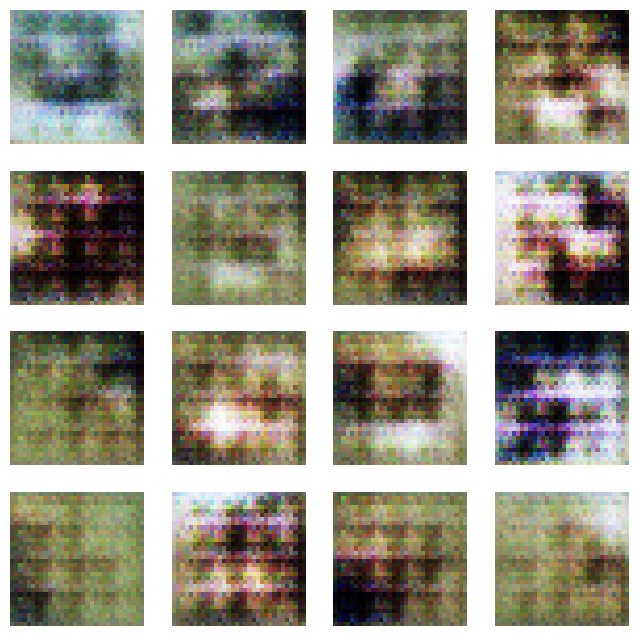

G(
  (net): Sequential(
    (0): ConvTranspose2d(100, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): Tanh()
  )
)

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Set the generator to evaluation mode
Gnet.eval()

# Generate some random noise
num_samples = 16
z = torch.randn(num_samples, z_dim, device=device)

# Generate fake images
with torch.no_grad():
    fake_images = Gnet(z).cpu()

# Denormalize the images
fake_images = fake_images * 0.5 + 0.5

# Display the images
fig, axes = plt.subplots(4, 4, figsize=(8, 8))
for i, ax in enumerate(axes.flat):
    ax.imshow(np.transpose(fake_images[i], (1, 2, 0)))
    ax.axis('off')
plt.show()

# Set the generator back to training mode
Gnet.train()